In [1]:
#Ning
#17 Nov
#Metaheuristics TP5

#import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random

In [2]:
#preliminary look at the X.dat file and Y.dat file
#Note that 0 corresponds to 'two' and 1 corresponds to 'three'

def transfer_file_to_arrays (filename):
    
    images = []
    
    with open(filename, "r") as fp:
        for line in fp:
            line = line.split(",") #split values on ,
            for i in range(0, len(line)):
                line[i] = float(line[i]) #turn into a float
            line = np.array(line)
            images.append(line) #append in np array format

    return images

def get_labels (filename):
    labels = []
    with open(filename, "r") as fp:
        for line in fp:
            labels.append(float(line))
    return labels

In [3]:
images = transfer_file_to_arrays("X.dat")
print(len(images)) #confirm that we have 200 images stored
print(images[0].shape[0]) #confirm the shape of the image
labels = get_labels("Y.dat")
print(len(labels))

200
400
200


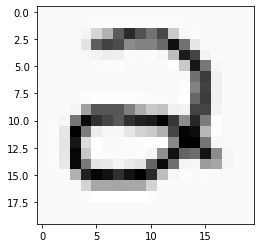

In [4]:
#show a sample of the image to see if we have one
plt.imshow(np.reshape(images[2], (20,20), order="F"), cmap="Greys")

In [5]:
def turn_two_to_one (theta1, theta2):
    return np.concatenate((theta1.flatten(), theta2.flatten()), axis=None)

def turn_one_to_two (big_theta):
    
    theta1 = np.reshape(big_theta[0:10025], (25,401)) #need to be careful here because of shape
    theta2 = np.reshape(big_theta[10025:], (1,26))
    
    return theta1, theta2

In [6]:
#testing
a = 6*np.zeros((25,401))-3
b = 6*np.full((1,26),1)-3

ab = turn_two_to_one(a,b)
c,d = turn_one_to_two(ab)

print(a==c)
print(b==d)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [7]:
def sigmoid (X):
    return 1/(1+np.exp(-X))

def first_layer (picture):
    '''
    first layer's role is to download the 400 pixels of the picture
    and have one neuron that is the bias 
    '''
    #add bias neuron
    layer_n = picture.shape[0]
    first_layer = np.insert(picture, 0, 1.0) #add 1 as the bias
    
    return first_layer

def second_layer (layer, theta):
    '''
    second layer contains 25 neurons, plus 1 for the bias
    job is to matmul the first layer's output with theta, apply sigmoid function, add bias
    
    theta is the matrix of size (25, 401)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (25,401)(401,) -> (25,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    res_n = res.shape[0] #should be 25
    
    second_layer = np.insert(res, 0, 1.0) #add 1 as the bias
    
    return second_layer

def third_layer (layer, theta):
    '''
    third layer contains 1 neuron
    job is to matmul the second layer's output with theta, apply sigmoid function, and return
    
    theta is the matrix of size (1, 26)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (1,26)(26,) -> (1,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    return res #should be a singular value answer, our prediction

def nn_predict (image, big_theta):
    '''
    application of all three layers
    '''
    
    #temporary values
    theta1, theta2 = turn_one_to_two(big_theta)
    
    layer1 = first_layer(image)
    layer2 = second_layer(layer1, theta1) #this theta value will take on PSO's output once complete
    layer3 = third_layer(layer2, theta2)
    
    return layer3[0] #the prediction    

In [8]:
#do some testing with values, we should be able to get a value
test = images[2]
print(nn_predict(test, ab))

0.9525741268224334


Well, that certainly looks like a value. Good job kense. Time to start PSO

In [9]:
def calc_fitness(big_theta, images, labels):
    fitness = 0.0
    for k in range(0, len(labels)):
        fitness+=(labels[k] - nn_predict(images[k], big_theta))**2
    return fitness/len(labels)

In [10]:
t1 = np.random.rand(25,401)
t2 = np.random.rand(1,26)
bt = turn_two_to_one(t1,t2)
print(calc_fitness(bt, images, labels))

0.4999998358959644


In [11]:
def init_positions ():
    return 2*np.random.rand(25,401)-1, 2*np.random.rand(1,26)-1

def init_velocities ():
    return np.zeros((25,401)), np.zeros((1,26))

In [31]:
def PSO (n, tmax, images, labels):
    
    #variables
    global_best = np.array([None,float('inf')]) #global_best is (position, fitness)
    inertia_constant = 0.9
    c1 = 1.99811 #defined by the assignment as close to 2
    c2 = 1.99899
    t = 0
    vmax = 0.1
    
    #initialize particles -> (s, v, b)
    particles = []
    for i in range(n):
        s0_a, s0_b = init_positions()
        v0_a, v0_b = init_velocities()
        
        big_s0 = turn_two_to_one(s0_a, s0_b)
        big_v0 = turn_two_to_one(v0_a, v0_b)
        particle = np.array([big_s0, big_v0, big_s0]) #personal_best init is s0
        particles.append(particle)
   
    
    while(t < tmax):
        
        #for each particle
        for i in range(n):
            fit = calc_fitness(particles[i][0], images, labels) #positions are taken to calc fitness
            pbest_fit = calc_fitness(particles[i][2], images, labels)
            if fit <= pbest_fit: #if better than personal_best
                particles[i][2] = particles[i][0][:] #copy as new best
                
        #set global_best
        for i in range(n):
            fit = calc_fitness(particles[i][2], images, labels)
            if fit <= global_best[1]: #if personal_best better than global_best
                global_best[1] = fit
                global_best[0] = particles[i][2][:] #set new values for global
        
        #particle updates
        for i in range(n):
            r1 = random.random()
            r2 = random.random()
            
            #update velocity
            particles[i][1] = inertia_constant*particles[i][1] + c1*r1*(particles[i][2]-particles[i][0]) + c2*r2*(global_best[0]-particles[i][0])
        
            #velocity cutoff?
            particles[i][1][particles[i][1] > vmax] = vmax
            particles[i][1][particles[i][1] < -1*vmax] = -1*vmax
        
            #update positions
            particles[i][0] = particles[i][0] + particles[i][1]
            
            #correct particles out of range
            for x in range(len(particles[i][0])):
                particles[i][0][x] -(2*(particles[i][0][x]-1))
                particles[i][0][x] + (2*-1-particles[i][0][x])
        
        t = t + 1
    
    #get the stats of the global_best
    theta1, theta2 = turn_one_to_two(global_best[0]) #separate global_best's particle into thetas
    return theta1, theta2 #return

In [32]:
#testing
a,b = PSO(20, 200, images, labels)

print(a,b)

[[-0.87902956  0.41202784  0.06868326 ...  1.44360784 -2.15932056
  -0.11701099]
 [ 0.9574316  -0.37029124  1.60767811 ...  1.60610327 -1.68633113
   1.65745898]
 [ 0.47258422  0.13568021 -0.71246439 ... -0.3049891  -0.08645079
   0.87158971]
 ...
 [ 1.83645446 -0.47021768 -0.47308597 ... -0.82817597  1.10459575
  -0.30783993]
 [-1.51451409 -0.29733571  0.77637438 ... -0.06315916 -0.84548599
   0.93269368]
 [-1.50482059 -0.46426116 -0.17088569 ...  1.19058158  0.46199736
   0.18259523]] [[ 0.56477558  0.65951498 -1.71828831  1.26080937 -0.17507657 -0.4533073
  -1.40591522 -1.42576633 -0.40503156 -2.59593694  0.67676166 -1.57900269
   1.01135022  2.05587701 -1.62656702  1.56758066 -0.25852327  2.15111362
  -1.9664551  -2.75574439 -0.53395857 -2.02269056  2.39411503 -0.36264384
  -1.71959399 -0.11439152]]


In [33]:
#error testing
correct = 0
predictions = []
for i in range(len(images)):
    predict = nn_predict(images[i], turn_two_to_one(a,b))
    predictions.append(predict)
    truth = labels[i]
    
    if truth == int(predict+0.5):
        correct += 1
print(correct/len(labels))

0.995


In [34]:
predictions

[0.9883285611461192,
 0.8093317168768582,
 0.9216042099190888,
 0.9087142775899818,
 0.9979610822664693,
 0.9915030577812324,
 0.9925601124431268,
 0.9968913456023422,
 0.9998960623391279,
 0.9558855039626178,
 0.9788660700983982,
 0.9997018530140812,
 0.9997392510268223,
 0.9324620226490292,
 0.9851958992109613,
 0.9689261711643419,
 0.9999558354410766,
 0.9454456683419136,
 0.9925931075546288,
 0.9685033954038469,
 0.9964368745811256,
 0.999975497560237,
 0.9988716523018145,
 0.9994882489089291,
 0.9960638290674119,
 0.9531249861443079,
 0.9687173592162518,
 0.9992534672639661,
 0.9971505838170748,
 0.9813975608508125,
 0.9262764549950957,
 0.9959743816670458,
 0.986877813030776,
 0.9944446634194941,
 0.9847257744167874,
 0.999686167111452,
 0.9974338882802765,
 0.9980378499910997,
 0.9949217680884017,
 0.9523672683071974,
 0.9961118847934669,
 0.9991166617701817,
 0.9976476901327298,
 0.9999391287401034,
 0.9999188865956438,
 0.9992704555479709,
 0.9999120836950681,
 0.9984087205305